In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!cp /content/drive/MyDrive/kaggle.json /content/kaggle.json
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ai-unict-2024-challenge-2-round-2
!unzip -q ai-unict-2024-challenge-2-round-2.zip -d ai-unict-2024-challenge-2-round-2

Mounted at /content/drive


## Reproducibility Settings and Random Seed Initialization

This block of code ensures reproducibility across different runs by setting a fixed random seed for all relevant libraries and frameworks involved in the training process.

In [ ]:

import os
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

generator = torch.Generator()
generator.manual_seed(SEED)


## Library Imports and Device Configuration

In [ ]:
import math
import shutil
from tqdm import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## Cropping Training Images Using Bounding Boxes


---
This block crops each training image using the bounding box coordinates provided in train.csv, saving the cropped images into class-specific folders. This isolates the object of interest and removes irrelevant background information, which is crucial to address the distribution shift between trai




In [ ]:

challenge_path = "/content/ai-unict-2024-challenge-2-round-2"
images_train_path = os.path.join(challenge_path, "train")
images_test_path = os.path.join(challenge_path, "test")
boundingbox_csv_path = os.path.join(challenge_path, "train.csv")
cropped_train_path = os.path.join(challenge_path, "train_cropped")

if os.path.exists(cropped_train_path):
    shutil.rmtree(cropped_train_path)
os.makedirs(cropped_train_path)

for class_id in range(8):
    os.makedirs(os.path.join(cropped_train_path, str(class_id)), exist_ok=True)

df = pd.read_csv(boundingbox_csv_path)

# Crop images
for _, row in tqdm(df.iterrows(), total=len(df), desc="Cropping train images"):
    image_name = row["image"]
    cls = row["class"]
    x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])

    image_path = os.path.join(images_train_path, image_name)

    if os.path.exists(image_path):
        try:
            image = Image.open(image_path).convert("RGB")
            cropped = image.crop((x1, y1, x2, y2))
            save_path = os.path.join(cropped_train_path, str(cls), os.path.basename(image_name))
            cropped.save(save_path)
        except Exception as e:
            print(f"Error with {image_path}: {e}")
    else:
        print(f"Image not found: {image_path}")


Cropping train images: 100%|██████████| 1600/1600 [00:14<00:00, 108.23it/s]


## Data Augmentation and Custom Dataset for Cropped Training Images

---
his block defines the transformation pipeline applied to each training image, including resizing, random flipping, rotation, color jittering, and normalization. A custom CroppedTrainDataset class is implemented to load images organized in class-specific folders. The data is then loaded into a DataLoader with a fixed seed for reproducibility and a batch size of 32. This setup is essential for training a robust and well-generalized model.


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class CroppedTrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for class_name in sorted(os.listdir(root_dir)):
            class_folder = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_folder):
                self.samples.append((os.path.join(class_folder, fname), int(class_name)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CroppedTrainDataset(root_dir=cropped_train_path, transform=train_transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    generator=generator  # ensure reproducibility
)


## Load Vision Transformer (ViT) and Extract Training Features

---
In this step, a pretrained Vision Transformer (vit_base_patch16_224) from the timm library is loaded and used as a fixed feature extractor. The classifier head is removed with reset_classifier(0), and the model is set to evaluation mode to disable weight updates. Each training image is passed through the model to extract a 768-dimensional feature vector. These features (X_train) and their corresponding labels (y_train) are stored for downstream tasks such as classification or clustering.


In [ ]:
vit = timm.create_model('vit_base_patch16_224', pretrained=True)
vit.reset_classifier(0)
vit = vit.to(device)
vit.eval()
print("ViT-B/16 loaded as feature extractor.")

X_train = []
y_train = []

with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="Extracting train features"):
        images = images.to(device)
        features = vit(images)  # shape: [B, 768]
        X_train.append(features.cpu().numpy())
        y_train.append(labels.numpy())

X_train = np.concatenate(X_train, axis=0)  # shape: (N_train, 768)
y_train = np.concatenate(y_train, axis=0)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


ViT-B/16 loaded as feature extractor.


Extracting train features: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


X_train shape: (1600, 768)
y_train shape: (1600,)


## Define Test Dataset and DataLoader

---
This block defines a custom TestImageDataset class for loading the test images, which are all stored in a single directory. Each image is read and optionally transformed using the same preprocessing pipeline as the training set. A DataLoader is then created to efficiently batch and iterate through the test data during inference. The filenames are retained for mapping predictions back to their respective images.


In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = sorted([os.path.join(root_dir, fname) for fname in os.listdir(root_dir)])
        self.filenames = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.filenames[idx]

test_dataset = TestImageDataset(root_dir=images_test_path, transform=train_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    generator=generator  # ensure reproducibility
)




## Extract Test Features using ViT


---
This block extracts feature vectors from the test images using a pretrained Vision Transformer (ViT-B/16) model. The model processes the test images in evaluation mode without updating weights. Each image is transformed into a 768-dimensional feature vector, which is stored along with its filename for later use in clustering or classification. The features are concatenated into a final array X_test, representing the entire test set.


In [ ]:
X_test = []
all_test_filenames = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader, desc="Extracting test features"):
        images = images.to(device)
        features = vit(images)  # shape: [B, 768]
        X_test.append(features.cpu().numpy())
        all_test_filenames.extend(filenames)

X_test = np.concatenate(X_test, axis=0)
print("X_test shape:", X_test.shape)
print("Total test images:", len(all_test_filenames))


Extracting test features: 100%|██████████| 25/25 [00:04<00:00,  5.44it/s]

X_test shape: (800, 768)
Total test images: 800


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


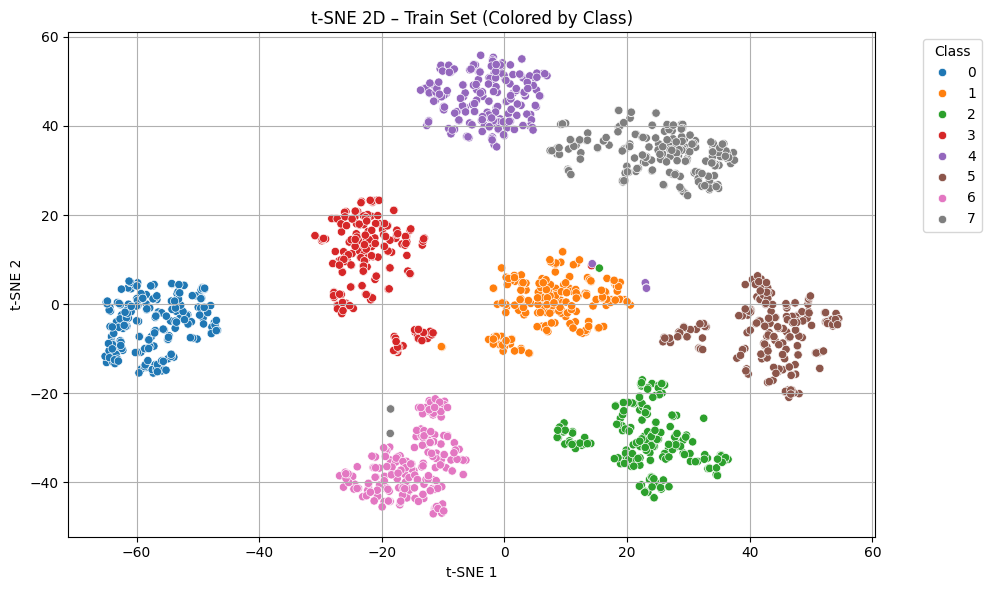

In [ ]:


# t-SNE for TRAIN set (with labels) 
tsne_train = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_train_tsne = tsne_train.fit_transform(X_train)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_train_tsne[:, 0],
    y=X_train_tsne[:, 1],
    hue=y_train,
    palette='tab10',
    legend='full'
)
plt.title("t-SNE 2D – Train Set (Colored by Class)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


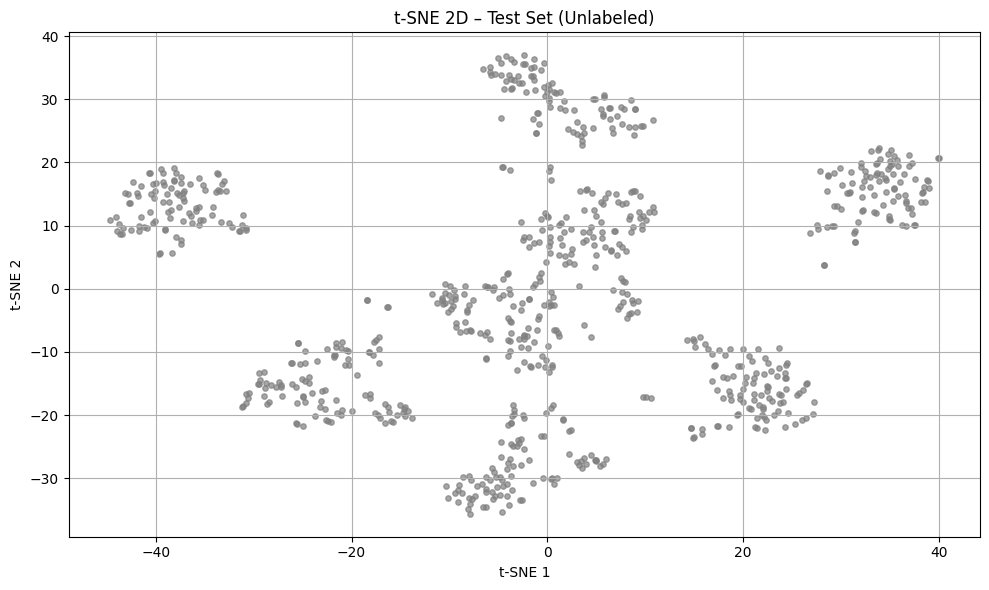

In [ ]:
# --- t-SNE for TEST set (no labels) ---
tsne_test = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_test_tsne = tsne_test.fit_transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], s=15, alpha=0.7, color='gray')
plt.title("t-SNE 2D – Test Set (Unlabeled)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Multi-Seed Clustering and Matching

---
This block performs KMeans clustering on the ViT-extracted test features using multiple random seeds. For each clustering result, the test cluster centroids are matched to the class centroids from the training set using the Hungarian algorithm. Class predictions are assigned based on this optimal mapping.
We evaluate the results for each seed using the standard deviation of the predicted class distribution and select the seed with the most balanced output (lowest std).


In [ ]:
# Compute fixed class centroids from training features
train_centroids = []
for cls_id in range(8):
    cls_features = X_train[y_train == cls_id]
    centroid = cls_features.mean(axis=0)
    train_centroids.append(centroid)
train_centroids = np.array(train_centroids)
print("Train centroids computed.")

# Test multiple random seeds for KMeans clustering on the test set
seeds_to_try = list(range(40, 50))
results = []

for seed in seeds_to_try:
    print(f"\nTesting KMeans with seed = {seed}")

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=8, random_state=seed, n_init=10)
    test_clusters = kmeans.fit_predict(X_test)
    test_centroids = kmeans.cluster_centers_

    # Perform optimal matching between test and train centroids
    distance_matrix = cdist(test_centroids, train_centroids, metric='euclidean')
    row_idx, col_idx = linear_sum_assignment(distance_matrix)
    cluster_map = {test: train for test, train in zip(row_idx, col_idx)}

    # Assign predicted labels
    y_pred = np.array([cluster_map[c] for c in test_clusters])

    # Calculate class distribution and std deviation
    unique, counts = np.unique(y_pred, return_counts=True)
    distribution = dict(zip(unique, counts))
    std_dev = np.std(list(distribution.values()))

    # Store results
    results.append({
        "seed": seed,
        "class_distribution": distribution,
        "std_dev": std_dev,
        "y_pred": y_pred
    })

    # Print current class distribution
    print("Predicted class distribution:")
    for cls_id in range(8):
        print(f"  Class {cls_id}: {distribution.get(cls_id, 0)} images")

# Select the best seed based on lowest standard deviation
best_run = min(results, key=lambda x: x["std_dev"])
print(f"\nBest seed based on class balance (lowest std deviation): {best_run['seed']}")
print("Best predicted class distribution:")
for cls_id in range(8):
    print(f"  Class {cls_id}: {best_run['class_distribution'].get(cls_id, 0)} images")


Train centroids computed.

Testing KMeans with seed = 40
Predicted class distribution:
  Class 0: 92 images
  Class 1: 92 images
  Class 2: 97 images
  Class 3: 130 images
  Class 4: 97 images
  Class 5: 100 images
  Class 6: 97 images
  Class 7: 95 images

Testing KMeans with seed = 41
Predicted class distribution:
  Class 0: 91 images
  Class 1: 93 images
  Class 2: 97 images
  Class 3: 121 images
  Class 4: 98 images
  Class 5: 100 images
  Class 6: 94 images
  Class 7: 106 images

Testing KMeans with seed = 42
Predicted class distribution:
  Class 0: 102 images
  Class 1: 93 images
  Class 2: 97 images
  Class 3: 110 images
  Class 4: 98 images
  Class 5: 100 images
  Class 6: 101 images
  Class 7: 99 images

Testing KMeans with seed = 43
Predicted class distribution:
  Class 0: 91 images
  Class 1: 92 images
  Class 2: 97 images
  Class 3: 131 images
  Class 4: 97 images
  Class 5: 100 images
  Class 6: 97 images
  Class 7: 95 images

Testing KMeans with seed = 44
Predicted class 

## Class Distribution Table per Seed

---
This block summarizes the predicted class distribution for each tested seed. For each KMeans run, we compute the number of samples assigned to each class and the standard deviation across these counts. A lower standard deviation indicates a more balanced distribution. The results are displayed in a sortable DataFrame for easy comparison.


In [ ]:
table_rows = []
for run in results:
    row_data = {"Seed": run["seed"], "STD_Dev": run["std_dev"]}
    for c in range(8):
        row_data[f"Class_{c}"] = run["class_distribution"].get(c, 0)
    table_rows.append(row_data)

df_results = pd.DataFrame(table_rows)
df_results = df_results.sort_values(by="STD_Dev")

print("\nClass distribution summary per seed:")
display(df_results)



Class distribution summary per seed:


,Seed,STD_Dev,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7
2,42,4.582576,102,93,97,110,98,100,101,99
5,45,4.582576,101,92,97,109,98,100,103,100
6,46,4.795832,99,93,97,109,98,100,98,106
8,48,4.949747,104,91,97,109,98,100,102,99
9,49,5.000000,102,93,97,111,98,100,102,97
4,44,6.041523,97,93,97,113,98,100,96,106
1,41,9.055385,91,93,97,121,98,100,94,106
0,40,11.618950,92,92,97,130,97,100,97,95
3,43,12.031209,91,92,97,131,97,100,97,95
7,47,13.397761,87,92,97,134,97,100,98,95


## Block – Cluster-to-Class Matching (Hungarian Algorithm)

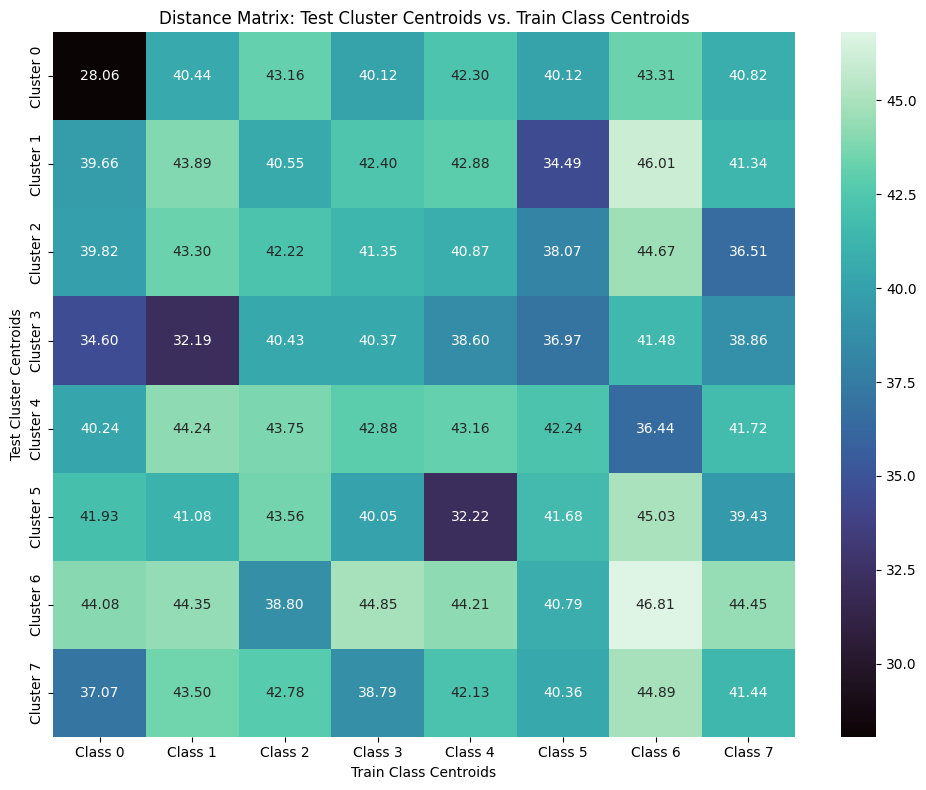

In [ ]:
# Recompute KMeans with the best seed
best_seed = best_run["seed"]
kmeans = KMeans(n_clusters=8, random_state=best_seed, n_init=10)
test_clusters = kmeans.fit_predict(X_test)
test_centroids = kmeans.cluster_centers_

# Compute the distance matrix between test cluster centroids and train class centroids
distance_matrix = cdist(test_centroids, train_centroids, metric='euclidean')

# Optimal cluster-to-class assignment using Hungarian algorithm
row_idx, col_idx = linear_sum_assignment(distance_matrix)

# Create the mapping dictionary
cluster_to_class = {cluster: cls for cluster, cls in zip(row_idx, col_idx)}

# Visualize the matrix with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="mako", cbar=True,
            xticklabels=[f"Class {i}" for i in range(8)],
            yticklabels=[f"Cluster {i}" for i in range(8)])
plt.title("Distance Matrix: Test Cluster Centroids vs. Train Class Centroids")
plt.xlabel("Train Class Centroids")
plt.ylabel("Test Cluster Centroids")
plt.tight_layout()
plt.show()


In [ ]:
# Save submission file using the best seed's predictions

best_seed = best_run["seed"]
best_pred = best_run["y_pred"]

submission_best = pd.DataFrame({
    "image": all_test_filenames,
    "class": best_pred
}).sort_values(by="image")

filename_best = f"submission_seed{best_seed}.csv"
submission_best_path = os.path.join(challenge_path, filename_best)
submission_best.to_csv(submission_best_path, index=False)

print(f"Submission saved with seed = {best_seed} at: {submission_best_path}")


Submission saved with seed = 42 at: /content/ai-unict-2024-challenge-2-round-2/submission_seed42.csv


In [ ]:
from google.colab import files
files.download(submission_best_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


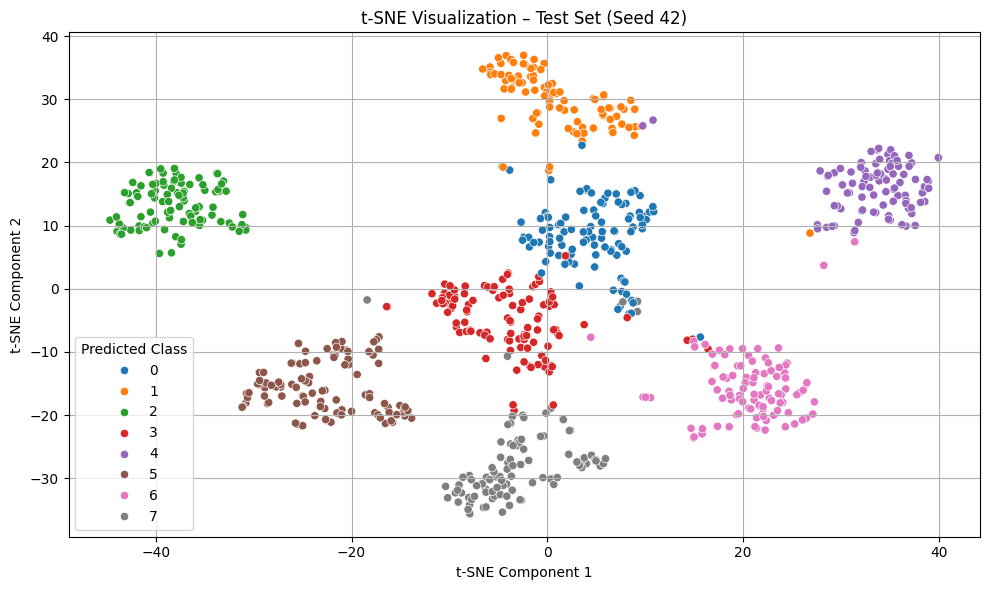

In [ ]:
# Visualize test set predictions using t-SNE (based on best seed)

from sklearn.manifold import TSNE

best_pred = best_run["y_pred"]

tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=best_seed)
X_test_2d = tsne_2d.fit_transform(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_test_2d[:, 0],
    y=X_test_2d[:, 1],
    hue=best_pred,
    palette='tab10',
    legend='full'
)
plt.title(f"t-SNE Visualization – Test Set (Seed {best_seed})")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.legend(title="Predicted Class")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd

def evaluate_kmeans_runs(seeds, all_preds, all_clusters, all_test_centroids, train_centroids, X_test):
    evaluations = []

    for seed, preds, clusters, test_centroids in zip(seeds, all_preds, all_clusters, all_test_centroids):
        # 1. STD Class Count (balanced class prediction)
        _, class_counts = np.unique(preds, return_counts=True)
        std_class = np.std(class_counts)

        # 2. Average Intra-Cluster Distance
        intra_dists = []
        for i in range(8):
            indices = np.where(clusters == i)[0]
            if len(indices) == 0:
                continue
            members = X_test[indices]
            centroid = test_centroids[i]
            dists = np.linalg.norm(members - centroid, axis=1)
            intra_dists.append(np.mean(dists))
        avg_intra_cluster = np.mean(intra_dists)

        # 3. Centroid Matching Distance (Hungarian algorithm)
        distance_matrix = cdist(test_centroids, train_centroids, metric='euclidean')
        row_idx, col_idx = linear_sum_assignment(distance_matrix)
        match_dist = distance_matrix[row_idx, col_idx].mean()

        evaluations.append({
            "Seed": seed,
            "STD_Class_Counts": round(std_class, 2),
            "Avg_IntraCluster_Dist": round(avg_intra_cluster, 2),
            "Centroid_Matching_Dist": round(match_dist, 2)
        })

    return pd.DataFrame(evaluations)


df_evaluation = evaluate_kmeans_runs(
    all_seeds,
    all_predictions,
    all_test_clusters,
    all_test_centroids,
    train_centroids,
    X_test
)

df_evaluation = df_evaluation.sort_values(by="STD_Class_Counts")
print(df_evaluation)


   Seed  STD_Class_Counts  Avg_IntraCluster_Dist  Centroid_Matching_Dist
2    42              4.58              26.320000                   34.69
5    45              4.58              26.320000                   34.68
6    46              4.80              26.299999                   34.69
8    48              4.95              26.309999                   34.69
9    49              5.00              26.320000                   34.69
4    44              6.04              26.309999                   34.67
1    41              9.06              26.320000                   34.63
0    40             11.62              26.309999                   34.60
3    43             12.03              26.320000                   34.60
7    47             13.40              26.309999                   34.58
